# Imports

First, we'll import the necessary libraries.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import datetime
import io
import zipfile
import rasterio
from rasterio.plot import show
import sklearn
from sklearn.neighbors import KernelDensity
import numpy as np

import collections

# in response to an error importing collections, I used this: https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python

from collections.abc import Iterable

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import mapclassify

Next, we'll query the City of Philadelphia data via the ArcGIS REST API using the `requests` library. We'll also use the `json` library to parse the response.

Finally, we'll use the `geopandas` library to create a geodataframe from the response.

We have three different datasets to import from the City's ArcGIS server. These are:

### 1. Vacant Land

In [2]:
# Define the URL for the Vacant_Indicators_Land feature service
land_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Land/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Land API request
land_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the Vacant_Indicators_Land API requests
land_dfs = []
land_offset = 0
while True:
    # Add the offset parameter to the API request
    land_params['resultOffset'] = land_offset
    land_response = requests.get(land_url, params=land_params)
    
    if land_response.status_code == 200:
        # Convert the Vacant_Indicators_Land JSON data to a geopandas geodataframe; convert to CRS 3857
        land_data = land_response.json()

        # convert the JSON data to a pandas dataframe
        land_df = pd.DataFrame(land_data['features'])

        # separate the attributes column into one column per attribute
        land_df = pd.concat([land_df.drop(['attributes'], axis=1), land_df['attributes'].apply(pd.Series)], axis=1)

        # make the `geometry` column a shapely geometry object
        land_df['geometry'] = land_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # convert the pandas dataframe to a geopandas geodataframe
        land_gdf = gpd.GeoDataFrame(land_df, geometry='geometry', crs='EPSG:3857')
        land_gdf.to_crs(epsg=2272, inplace=True)

        land_dfs.append(land_gdf)
        land_offset += len(land_gdf)
        
        if len(land_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data
        
    else:
        print('Vacant_Indicators_Land Request failed with status code:', land_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
land_gdf = gpd.GeoDataFrame(pd.concat(land_dfs, ignore_index=True), crs='EPSG:2272')


In [3]:
land_gdf.shape

(26290, 14)

### 2. Vacant Buildings

In [4]:
# Define the URL for the Vacant_Indicators_Bldg feature service
bldg_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Bldg/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Bldg API request
bldg_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the Vacant_Indicators_Bldg API requests
bldg_dfs = []
bldg_offset = 0
while True:
    # Add the offset parameter to the API request
    bldg_params['resultOffset'] = bldg_offset
    bldg_response = requests.get(bldg_url, params=bldg_params)
    
    if bldg_response.status_code == 200:
        # Convert the Vacant_Indicators_bldg JSON data to a geopandas geodataframe; convert to CRS 3857
        bldg_data = bldg_response.json()

        # convert the JSON data to a pandas dataframe
        bldg_df = pd.DataFrame(bldg_data['features'])

        # separate the attributes column into one column per attribute
        bldg_df = pd.concat([bldg_df.drop(['attributes'], axis=1), bldg_df['attributes'].apply(pd.Series)], axis=1)

        # make the `geometry` column a shapely geometry object
        bldg_df['geometry'] = bldg_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # convert the pandas dataframe to a geopandas geodataframe
        bldg_gdf = gpd.GeoDataFrame(bldg_df, geometry='geometry', crs='EPSG:3857')
        bldg_gdf.to_crs(epsg=2272, inplace=True)

        bldg_dfs.append(bldg_gdf)
        bldg_offset += len(bldg_gdf)
        
        if len(bldg_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data
        
    else:
        print('Vacant_Indicators_Bldg Request failed with status code:', bldg_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
bldg_gdf = gpd.GeoDataFrame(pd.concat(bldg_dfs, ignore_index=True), crs='EPSG:2272')

In [5]:
bldg_gdf.shape

(9712, 14)

### Now, combine the two datasets in preparation for string cleaning.

In [6]:
columns = ['geometry', 'ADDRESS', 'BLDG_DESC',
       'OPA_ID','COUNCILDISTRICT',
       'ZIPCODE','OWNER1', 'OWNER2']

# reduce gdfs to only the columns we want
land_gdf = land_gdf[columns]

bldg_gdf = bldg_gdf[columns]

land_gdf['type'] = 'Lot'

bldg_gdf['type'] = 'Building'

In [7]:
# bind the two geodataframes together using pandas.concat
full_gdf = pd.concat([land_gdf, bldg_gdf], axis=0)

In [8]:
full_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,OWNER1,OWNER2,type
0,"POLYGON ((2687288.180 256633.076, 2687182.041 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,NEWCOURTLAND ELDER SVCS,None,Lot
1,"POLYGON ((2675580.787 242097.596, 2675611.032 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,REDEVELOPMENT AUTHORITY,OF PHILADELPHIA,Lot
2,"POLYGON ((2694595.619 250002.049, 2694595.572 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,REDEVELOPMENT AUTHORITY,OF PHILADELPHIA,Lot
3,"POLYGON ((2699250.966 246745.116, 2699244.163 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,MCHUGH JOHN,None,Lot
4,"POLYGON ((2695073.865 251698.897, 2695026.121 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,HERBERT MITCHELL,VICTORIA,Lot


### Now we'll apply string cleaning to the OWNER1 and OWNER2 columns to identify public vs. private ownership.

In [9]:
public_owners = ['PHILADELPHIA LAND BANK',
                'PHILADELPHIA HOUSING AUTH',
                'CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA',
                'DEPT OF PUBLIC PROP; CITY OF PHILA',
                'DEPT PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILA',
                'PHILA REDEVELOPMENT AUTH',
                'PHILADELPHIA LAND INVESTM',
                'REDEVELOPMENT AUTHORITY O',
                'PHILADELPHIA REDEVELOPMEN',
                'PHILA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING',
                'PHILA REDEVELOPMENT AUTHO',
                'DEPT OF PUB PROP; CITY OF PHILA',
                'PHILA HOUSING DEV CORP',
                'DEP OF PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY',
                'COMMONWEALTH OF PA',
                'COMMONWEALTH OF PENNA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA',
                'PUBLIC PROP DIV; CITY OF PHILA',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                'REAL ESTATE DIV; CITY OF PHILA',
                'REAL ESTATE DIVISION; CITY OF PHILA',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING'
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMENT AUTH',
                'PHILADELPHIA HOUSING AUTHORITY',
                'PHILADELPHIA LAND BANK',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHORITY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PENNSYLVANIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PENNDOT'
]

# return unique public_owners
public_owners = list(set(public_owners))

In [10]:
# create a new column that combines the OWNER1 and OWNER2 columns according to the following rules:
# if OWNER1 is not null and OWNER2 is null, then the new column is OWNER1
# if OWNER1 is null and OWNER2 is not null, then the new column is OWNER2
# if OWNER2 starts with a preposition, then the new column is OWNER1 + OWNER2 separated by a space
# if OWNER2 does not start with a preposition, then the new column is OWNER2 + OWNER1 separated by a se


# define a function to check if a string starts with a preposition
def starts_with_preposition(string):
    prepositions = ['a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'from', 'in', 'into', 'nor', 'of', 'on', 'or', 'so', 'the', 'to', 'up', 'yet']
    if string.split(' ')[0].lower() in prepositions:
        return True
    else:
        return False
    
# define a function to combine the OWNER1 and OWNER2 columns
def combine_owners(row):
    if pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return None
    elif pd.isnull(row['OWNER1']) and not pd.isnull(row['OWNER2']):
        return row['OWNER2']
    elif not pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return row['OWNER1']
    elif starts_with_preposition(row['OWNER2']):
        return row['OWNER1'] + ' ' + row['OWNER2']
    else:
        return row['OWNER2'] + '; ' + row['OWNER1']
    
# apply the combine_owners function to the full_gdf dataframe
full_gdf['OWNER'] = full_gdf.apply(combine_owners, axis=1)

# if OWNER is 'PHILADELPHIA HOUSING AUTH' or 'PHILA HOUSING AUTHORITY', replace with 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILADELPHIA HOUSING AUTH', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING AUTHORITY', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'

# redevelopment authority typos
redev_owner_variations = ['REDEVELOPMENT AUTHORITY OF PHILA', 'PHILA REDEVELOPMENT AUTH',
'REDEVELOPMENT AUTHORITY O', 'PHILADELPHIA REDEVELOPMEN',
'PHILA REDEVELOPMENT AUTHO', 'REDEVELOPMENT AUTHORITY',
'REDEVELOPMENT AUTH']

for var in redev_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA'

# department of public property typos
dpp_owner_variations = ['DEPT OF PUBLIC PROPERTY', 'DEPT OF PUBLIC PROPERT', 'DEPT OF PUBLC PROP; CITY OF PHILA',
                        'DEPT OF PUBLIC PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROPERTY; CITY OF PHILA', 'DEPT PUB PROP; CITY OF PHILA',
                        'DEPT OF PUB PROP; CITY OF PHILA', 'DEP OF PUB PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                        'DEPT PUBLIC PROP R E DIV; CITY OF PHILA', 'PUBLIC PROP DIV; CITY OF PHILA', 'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                        'REAL ESTATE DIV; CITY OF PHILA', 'REAL ESTATE DIVISION; CITY OF PHILA']

for var in dpp_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY'

# HUD
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'

# commonwealth of pennsylvania
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PENNA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'

# phdc
full_gdf.loc[full_gdf['OWNER'] == 'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING DEV CORP', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'

# PennDOT
full_gdf.loc[full_gdf['OWNER'] == 'DEPARTMENT OF TRANSPORTAT; COMMONWEALTH OF PENNSYLVA', 'OWNER'] = 'PENNDOT'

# city of Philadelphia
full_gdf.loc[full_gdf['OWNER'] == 'CITY OF PHILADELPHIA', 'OWNER'] = 'CITY OF PHILA'

# create a new column called 'public_owner' that is True if the OWNER column is in the public_owners list
full_gdf['public_owner'] = full_gdf['OWNER'].isin(public_owners)

# drop the OWNER1 and OWNER2 columns
full_gdf = full_gdf.drop(['OWNER1', 'OWNER2'], axis=1)

In [11]:
# randomly sample ten rows from the full_gdf dataframe
full_gdf.sample(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner
14521,"POLYGON ((2694055.750 255781.182, 2694056.572 ...",3419 N 19TH ST,VAC LAND RES < ACRE,112268700,8,19140,Lot,CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROP...,True
12186,"POLYGON ((2682877.541 240461.269, 2682778.121 ...",673 UNION ST,VAC LAND RES < ACRE,242234800,3,19104,Lot,COMMONWEALTH IMPROVEMENT,False
17418,"POLYGON ((2692596.497 257340.305, 2692611.782 ...",3634 N 22ND ST,VAC LAND RES < ACRE,131299000,8,19140,Lot,GIBSON HELEN; GIBSON LIONEL,False
23709,"POLYGON ((2695607.999 270441.409, 2695605.091 ...",1964 CHURCH LN,VAC LAND RES < ACRE,171235900,8,19141,Lot,XM LAND DEVELOPMENT LLC,False
5128,"POLYGON ((2701368.509 248677.961, 2701366.854 ...",2353 MUTTER ST,VAC LAND RES < ACRE,191071501,7,19133,Lot,MALAVE HECTOR,False
13683,"POLYGON ((2681062.830 242384.893, 2681065.547 ...",910 N HOLLY ST,VAC LAND RES < ACRE,062270610,3,19104,Lot,CITY OF PHILA,True
20199,"POLYGON ((2702005.583 254723.139, 2702003.992 ...",3431 PALETHORP ST,VAC LAND RES < ACRE,072080300,7,19140,Lot,LYDIA HOMES RUSK LLC,False
921,"POLYGON ((2689607.410 266905.301, 2689643.949 ...",29-79 E CHELTEN AVE,SHOP.CENT. N'HOOD MASONRY,882841700,8,19144,Building,MAIN LINE FEDERAL SAVINGS; CHELTEN RETAIL PART...,False
8912,"POLYGON ((2691661.453 247430.112, 2691659.446 ...",1909 N VAN PELT ST,VAC LAND RES < ACRE,322068201,5,19121,Lot,CITY OF PHILA,True
7002,"POLYGON ((2672858.938 222821.426, 2672847.891 ...",7016 WHEELER ST,ROW B/GAR 2STY MASONRY,406203800,2,19142,Building,COMARA MUHAMED,False


### 3. PHS Community Landcare Parcels

Now we can import the PHS Community LandCare parcels and spatially join them to our full_gdf, which contains all of the vacant parcels in the city (both lots and buildings).

In [12]:
# Define the URL for the PHS_CommunityLandcare feature service
phs_landcare_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_CommunityLandcare/FeatureServer/0/query'

# Define the parameters for the PHS_CommunityLandcare API request
phs_landcare_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the PHS_CommunityLandcare API requests
phs_dfs = []
phs_offset = 0
while True:
    # Add the offset parameter to the API request
    phs_landcare_params['resultOffset'] = phs_offset
    phs_landcare_response = requests.get(phs_landcare_url, params=phs_landcare_params)
    
    if phs_landcare_response.status_code == 200:
        # Convert the PHS_CommunityLandcare JSON data to a geopandas geodataframe; convert to CRS 3857
        phs_landcare_data = phs_landcare_response.json()

        # convert the JSON data to a pandas dataframe
        phs_landcare_df = pd.DataFrame(phs_landcare_data['features'])

        # separate the attributes column into one column per attribute
        phs_landcare_df = pd.concat([phs_landcare_df.drop(['attributes'], axis=1), phs_landcare_df['attributes'].apply(pd.Series)], axis=1)

        # make the `geometry` column a shapely geometry object
        phs_landcare_df['geometry'] = phs_landcare_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # convert the pandas dataframe to a geopandas geodataframe
        phs_landcare_gdf = gpd.GeoDataFrame(phs_landcare_df, geometry='geometry', crs='EPSG:3857')
        phs_landcare_gdf.to_crs(epsg=2272, inplace=True)

        phs_dfs.append(phs_landcare_gdf)
        phs_offset += len(phs_landcare_gdf)
        
        if len(phs_landcare_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data
        
    else:
        print('PHS_CommunityLandcare Request failed with status code:', phs_landcare_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
phs_landcare_gdf = gpd.GeoDataFrame(pd.concat(phs_dfs, ignore_index=True), crs='EPSG:2272')

phs_cols = ['geometry', 'COMM_PARTN']

phs_landcare_gdf = phs_landcare_gdf[phs_cols]

In [13]:
phs_landcare_gdf.shape

(2263, 2)

In [14]:
# spatially join phs_landcare_gdf to full_gdf
joined_gdf = gpd.sjoin(full_gdf, phs_landcare_gdf, how='left', predicate='intersects')

# drop the index_right column and the ADDRESS_right column
joined_gdf = joined_gdf.drop(['index_right'], axis=1)

joined_gdf['COMM_PARTN'] = joined_gdf['COMM_PARTN'].fillna('None', inplace=True)

In [15]:
joined_gdf.columns

Index(['geometry', 'ADDRESS', 'BLDG_DESC', 'OPA_ID', 'COUNCILDISTRICT',
       'ZIPCODE', 'type', 'OWNER', 'public_owner', 'COMM_PARTN'],
      dtype='object')

Now we need to import two more datasets from the City's Carto database (SQL).

### 1. L&I Complaints

In [16]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
complaints_sql_query = "SELECT address, service_request_id, subject, status, service_name, service_code, lat, lon FROM public_cases_fc WHERE requested_datetime >= '{}'".format(one_year_ago)

# Make the GET request
complaints_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": complaints_sql_query})

# Get the data
complaints_data = complaints_response.json()["rows"]

# convert complaints_data to a pandas dataframe
complaints_df = pd.DataFrame(complaints_data)

# Convert the data to a geopandas dataframe
complaints_gdf = gpd.GeoDataFrame(complaints_df, geometry=gpd.points_from_xy(complaints_df.lon, complaints_df.lat), crs='EPSG:2272')

# drop the lat and lon columns
complaints_gdf.drop(['lat', 'lon'], axis=1, inplace=True)

# filter for only Status = 'Open'
complaints_gdf = complaints_gdf[complaints_gdf['status'] == 'Open']

# collapse complaints_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
complaints_gdf = complaints_gdf.groupby('address')['service_name'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_complaints'
complaints_gdf.rename(columns={'service_name': 'li_complaints'}, inplace=True)


In [17]:
complaints_gdf.shape

(40955, 2)

### 2. L&I Code Violations

In [18]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
violations_sql_query = "SELECT parcel_id_num, casenumber, casecreateddate, casetype, casestatus, violationnumber, violationcodetitle, violationstatus, opa_account_num, address, opa_owner, geocode_x, geocode_y FROM violations WHERE violationdate >= '{}'".format(one_year_ago)

# Make the GET request
violations_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": violations_sql_query})

# Get the data
violations_data = violations_response.json()["rows"]

# convert violations_data to a pandas dataframe
violations_df = pd.DataFrame(violations_data)

# Convert the data to a geopandas dataframe
violations_gdf = gpd.GeoDataFrame(violations_df, geometry=gpd.points_from_xy(violations_df.geocode_x, violations_df.geocode_y), crs='EPSG:2272')

# drop the lat and lon columns
violations_gdf.drop(['geocode_x', 'geocode_y'], axis=1, inplace=True)

# filter for only cases where the casestatus is 'IN VIOLATION' or 'UNDER INVESTIGATION'
violations_gdf = violations_gdf[(violations_gdf['violationstatus'] == 'OPEN')]

# collapse violations_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
violations_gdf = violations_gdf.groupby('opa_account_num')['violationcodetitle'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_violations'
violations_gdf.rename(columns={'violationcodetitle': 'li_code_violations'}, inplace=True)

In [19]:
violations_gdf.shape

(11647, 2)

In [20]:
# left join the complaints_gdf to the joined_gdf on address
joined_gdf = joined_gdf.merge(complaints_gdf, how='left', left_on='ADDRESS', right_on='address')

# left join the violations_gdf to the joined_gdf on opa_account_num
joined_gdf = joined_gdf.merge(violations_gdf, how='left', left_on='OPA_ID', right_on='opa_account_num')

# drop the address and opa_account_num columns
joined_gdf.drop(['address', 'opa_account_num'], axis=1, inplace=True)

### Next, we'll add a centroids column to the joined_gdf in order to make it easier to cleanly join neighborhoods, RCOs, tree canopy, and guncrime data.

Joining by points rather than polygons makes it far less likely that a point straddles two polygons, which make the join ambiguous and potentially incorrect.

In [21]:
# add a column for centroids geometry to use for joins and to extrct raster values
joined_gdf['centroid'] = joined_gdf['geometry'].centroid

# create a geodata of polygon geoms and opa_id
poly_gdf = joined_gdf[['OPA_ID', 'geometry']]

# drop the 'geometry' column from joined_gdf
joined_gdf.drop(['geometry'], axis=1, inplace=True)

# set the 'centroid' column as the geometry column
joined_gdf.set_geometry('centroid', inplace=True)

### Import Philadelphia's Neighborhoods from Azavea

In [22]:
hoods_url = 'https://github.com/azavea/geo-data/raw/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.zip'

hoods_response = requests.get(hoods_url)

with io.BytesIO(hoods_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
hoods = gpd.read_file("path/to/destination/folder/Neighborhoods_Philadelphia.shp")

hoods = hoods.to_crs(epsg=2272)

In [23]:
joined_gdf = gpd.sjoin(joined_gdf, hoods, how='left', predicate='intersects')

joined_gdf = joined_gdf.drop(['index_right', 'NAME', 'LISTNAME', 'Shape_Leng', 'Shape_Area'], axis=1)

joined_gdf.rename(columns={'MAPNAME': 'neighborhood'}, inplace=True)

### Import RCOs from the City

In [24]:
# Define the URL for the RCOs feature service
rcos_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Zoning_RCO/FeatureServer/0/query'

# Define the parameters for the RCOs API request
rcos_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the RCOs API request
rcos_response = requests.get(rcos_url, params=rcos_params)

# Check if the RCOs request was successful
if rcos_response.status_code == 200:
    # Convert the RCOs JSON data to a geopandas geodataframe; convert to CRS 3857
    rcos_data = rcos_response.json()

    # convert the JSON data to a pandas dataframe
    rcos_df = pd.DataFrame(rcos_data['features'])

    # separate the attributes column into one column per attribute
    rcos_df = pd.concat([rcos_df.drop(['attributes'], axis=1), rcos_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('RCOs Request failed with status code:', rcos_response.status_code)


# make the `geometry` column a shapely geometry object
rcos_df['geometry'] = rcos_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
rcos_gdf = gpd.GeoDataFrame(rcos_df, geometry='geometry', crs='EPSG:3857')

rcos_gdf.to_crs(epsg=2272, inplace=True)

rcos_cols = ['geometry', 'ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS',
       'ORG_TYPE', 'PREFFERED_CONTACT_METHOD',
       'PRIMARY_NAME', 'PRIMARY_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE',
       'EXPIRATIONYEAR']

# convert primary_phone and expirationyear to strings
rcos_gdf['PRIMARY_PHONE'] = rcos_gdf['PRIMARY_PHONE'].astype(str)
rcos_gdf['EXPIRATIONYEAR'] = rcos_gdf['EXPIRATIONYEAR'].astype(str)

In [25]:
rco_aggregate_cols = ['ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE']

rcos_gdf["rco_info"] = rcos_gdf[rco_aggregate_cols].agg("; ".join, axis=1)

In [26]:
rcos_final_cols = ['geometry', 'rco_info']

rcos_gdf = rcos_gdf[rcos_final_cols]

### Now we can join the RCOs to the joined_gdf.

In [27]:
# spatially join rcos_gdf to joined_gdf
w_rcos_gdf = gpd.sjoin(joined_gdf, rcos_gdf, how='left', predicate='within')

# drop the index_right column
w_rcos_gdf = w_rcos_gdf.drop(['index_right'], axis=1)

# change MAPNAME to neighborhood

w_rcos_gdf.rename(columns={'rco_info': 'rco_info'}, inplace=True)

# remove duplicates by OPA_ID
w_rcos_gdf = w_rcos_gdf.drop_duplicates(subset='OPA_ID')

In [28]:
# plot w_rcos_gdf
w_rcos_gdf.shape

(35805, 14)

In [29]:
# make OPA_ID a string
w_rcos_gdf['OPA_ID'] = w_rcos_gdf['OPA_ID'].astype(str)

# collapse w_rcos_gdf by opa_id and concatenate the rco_info values into a list with a | separator
rcos_by_opa_id_gdf = w_rcos_gdf.groupby('OPA_ID')['rco_info'].apply(lambda x: '| '.join([str(val) for val in x if val is not None])).reset_index()

# rename the column to 'relevant_rcos'
rcos_by_opa_id_gdf.rename(columns={'rco_info': 'relevant_rcos'}, inplace=True)

In [30]:
rcos_by_opa_id_gdf.shape

(35805, 2)

In [31]:
# left join the rcos_by_opa_id_gdf to the joined_gdf on opa_id
joined_gdf = joined_gdf.merge(rcos_by_opa_id_gdf, how='left', left_on='OPA_ID', right_on='OPA_ID')

# drop duplicate rows
joined_gdf = joined_gdf.drop_duplicates(subset='OPA_ID')


In [32]:
joined_gdf.shape

(35805, 14)

In [33]:
joined_gdf.sample(5)

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos
11709,3024 N LAMBERT ST,VAC LAND RES < ACRE,111279405,8,19132,Lot,HAWK RICHARD C,False,None,NaN,NaN,POINT (2692754.624 253653.163),Glenwood,"Tioga United, Inc.; 1539 W. Venango Street \r\..."
16785,2238 W OAKDALE ST,VAC LAND RES < ACRE,162334800,5,19132,Lot,SMITH KYLE,False,None,NaN,NaN,POINT (2691584.401 251609.486),Strawberry Mansion,North Penn Community Action Council; 2423 N 27...
30439,2815 W HAROLD ST,ROW 2 STY MASONRY,281326200,5,19132,Building,CONYERS ANTHONY L; MOORE JEAN T/F,False,None,Maintenance Complaint; Maintenance Complaint,VACANT STRUCTURE & LAND; EXTERIOR STRUCTURE PR...,POINT (2689112.145 251831.314),Strawberry Mansion,North Penn Community Action Council; 2423 N 27...
25231,422 E CAMBRIA ST,VAC LAND RES < ACRE,071218400,7,19134,Lot,CLARKE MELVIN JR,False,None,NaN,NaN,POINT (2704290.041 251232.516),Upper Kensington,Impact Community Development Corporation; 1952...
16936,1940 N UBER ST,VAC LAND RES < ACRE,321279301,5,19121,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2692520.549 247571.729),North Central,Temple Area Property Association (TAPA); 1639 ...


### Finally, tree canopy data.

In [34]:
tree_url = 'https://national-tes-data-share.s3.amazonaws.com/national_tes_share/pa.zip.zip'

tree_response = requests.get(tree_url)

with io.BytesIO(tree_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
pa = gpd.read_file("path/to/destination/folder/pa.shp")

pa = pa.to_crs(epsg=2272)

phl = pa[pa['county'] == 'Philadelphia County']

tree_cols = ['tc_gap', 'geometry']

phl = phl[tree_cols]

phl.rename(columns={'tc_gap': 'tree_canopy_gap'}, inplace=True)

phl.head()

,tree_canopy_gap,geometry
5395,0.216832,"POLYGON ((2698038.313 234970.868, 2697586.173 ..."
5396,0.196093,"POLYGON ((2699640.691 237442.051, 2699638.100 ..."
5397,0.297005,"POLYGON ((2696855.043 237339.498, 2696827.290 ..."
5398,0.346134,"POLYGON ((2693798.320 238055.129, 2693725.464 ..."
5399,0.097603,"POLYGON ((2689575.081 237146.348, 2689561.703 ..."


In [35]:
# spatially join phl to joined_gdf
joined_gdf = gpd.sjoin(joined_gdf, phl, how='left', predicate='intersects')

joined_gdf = joined_gdf.drop(['index_right'], axis=1)

# drop duplicate opa_ids
joined_gdf = joined_gdf.drop_duplicates(subset='OPA_ID')

In [36]:
joined_gdf.shape

(35805, 15)

In [37]:
joined_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos,tree_canopy_gap
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,NaN,POINT (2687670.347 256881.319),Allegheny West,"East Falls Community Council; PO Box 12672, 19...",0.230223
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2675594.486 242078.492),Haddington,Parkside Association; Parkside Evans Recreatio...,0.104381
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2694579.519 249996.821),Stanton,Uptown Entertainment and Development Corporati...,0.165151
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN,POINT (2699241.653 246723.548),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...,0.199069
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,POINT (2695050.897 251708.887),Stanton,"Tioga United, Inc.; 1539 W. Venango Street \r\...",0.327281


<AxesSubplot: >

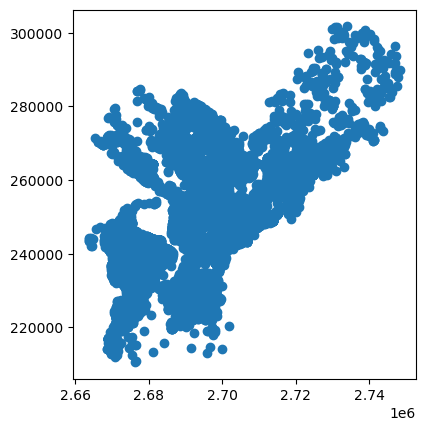

In [38]:
# plot the joined_gdf
joined_gdf.plot()


# Gun Crimes

For our gun crime kernel density estimate, we have two steps:

### 1. Import gun crime data from the City's Carto database (SQL):

In [39]:
# Modify the SQL query
guncrime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Aggravated Assault Firearm', 'Robbery Firearm')".format(one_year_ago)

# Make the GET request
guncrime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrime_sql_query})

# Get the data
guncrime_data = guncrime_response.json()["rows"]

# convert guncrime_data to a pandas dataframe
guncrime_df = pd.DataFrame(guncrime_data)

# Convert the data to a geopandas dataframe
guncrime_gdf = gpd.GeoDataFrame(guncrime_df, geometry=gpd.points_from_xy(guncrime_df.point_x, guncrime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
guncrime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
guncrime_gdf.to_crs(epsg=2272, inplace=True)

# drop null geometry values
guncrime_gdf = guncrime_gdf[guncrime_gdf['geometry'].notnull()]

c:\Users\Nissim\.conda\envs\vac_props_guncrime_dash\Lib\site-packages\geopandas\geoseries.py:751: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [40]:
guncrime_gdf.head()

,text_general_code,dispatch_date,geometry
0,Aggravated Assault Firearm,2023-03-11,POINT (2701499.535 254526.843)
1,Aggravated Assault Firearm,2023-02-26,POINT (2687640.067 228769.524)
2,Aggravated Assault Firearm,2023-02-26,POINT (2713880.495 277084.082)
3,Aggravated Assault Firearm,2023-03-11,POINT (2693641.218 272699.592)
4,Robbery Firearm,2023-02-22,POINT (2686795.469 250843.175)


In [41]:
guncrime_gdf.shape

(6124, 3)

### 2. Create a kernel density estimate from the gun crime data:

Note that, rather than following the one mile bandwidth used in the original research, I'm using an adaptive bandwidth based on Silverman's rule to account for varying local densities. Silverman's is more robust than Scott's method as well. I'm implementing this in scipy's gaussian_kde function.

\Silverman, B., 1986. Density estimation for statistic and data analysis. London, UK: Chapman and Hall. https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf.

Note that ArcGIS Pro implements Silverman's Rule of Thumb: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-kernel-density-works.htm

However, I really need to look into this more to make sure that I've implemented it correctly. The distribution of my data is non-parametric, meaning that neither Scott's nor Silverman's methods are appropriate.

In [42]:
from scipy.stats import gaussian_kde

# Get X and Y coordinates of well points
x_sk = guncrime_gdf["geometry"].x
y_sk = guncrime_gdf["geometry"].y

# drop null values
x_sk = x_sk.dropna()
y_sk = y_sk.dropna()

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = guncrime_gdf.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()])

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk])

# Estimate the bandwidth using Silverman's rule, which is more robust than Scott's
kde_sk = gaussian_kde(Xtrain_sk, bw_method='silverman')

# Evaluate the estimator on coordinate pairs
Z_sk = kde_sk(positions_sk)

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

<AxesSubplot: ylabel='Density'>

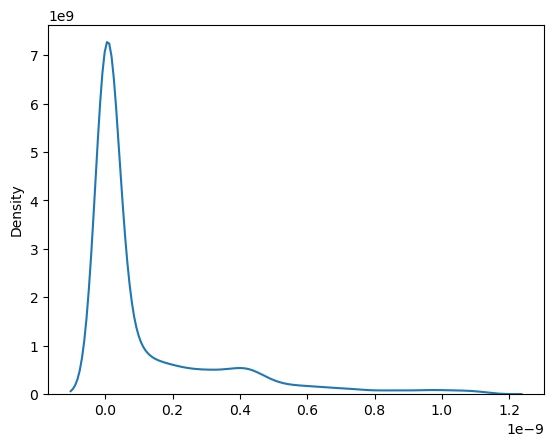

In [43]:
import seaborn as sns

sns.kdeplot(Z_sk.ravel())

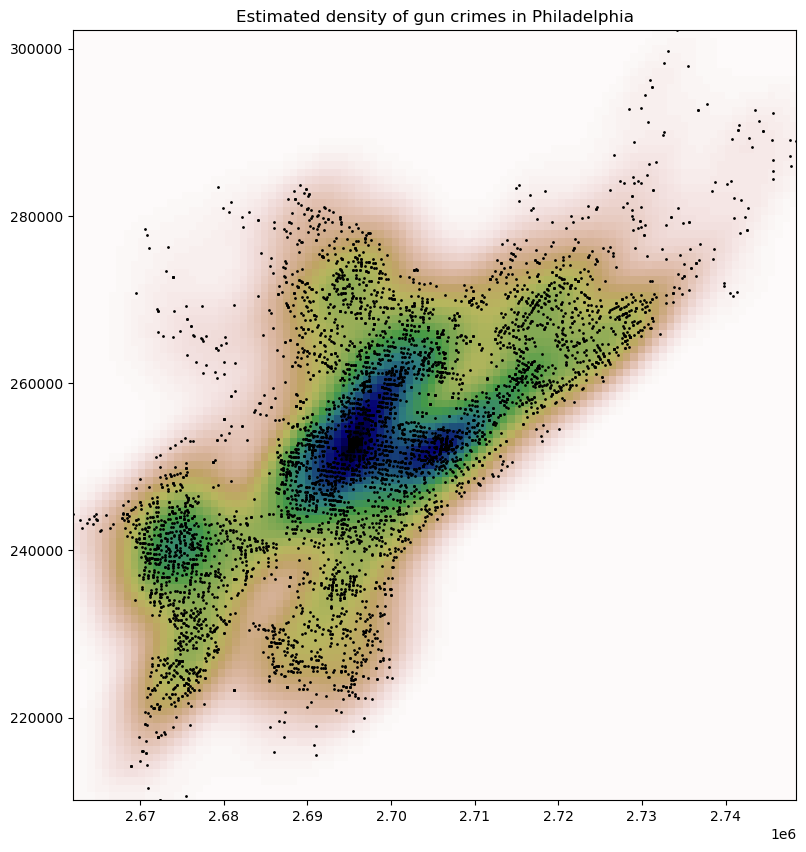

In [44]:
# plot Z_sk
plt.figure(figsize=(10,10))
plt.imshow(np.rot90(Z_sk), cmap=plt.cm.gist_earth_r, extent=[min_x_sk, max_x_sk, min_y_sk, max_y_sk])
plt.plot(x_sk, y_sk, 'k.', markersize=2)
plt.title('Estimated density of gun crimes in Philadelphia')
plt.show()

In [45]:
today = datetime.datetime.today().strftime('%Y_%m_%d')


def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
kde_filename = f"C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast_{today}.tif"
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = kde_filename)

In [46]:
src = rasterio.open(kde_filename)

<AxesSubplot: >

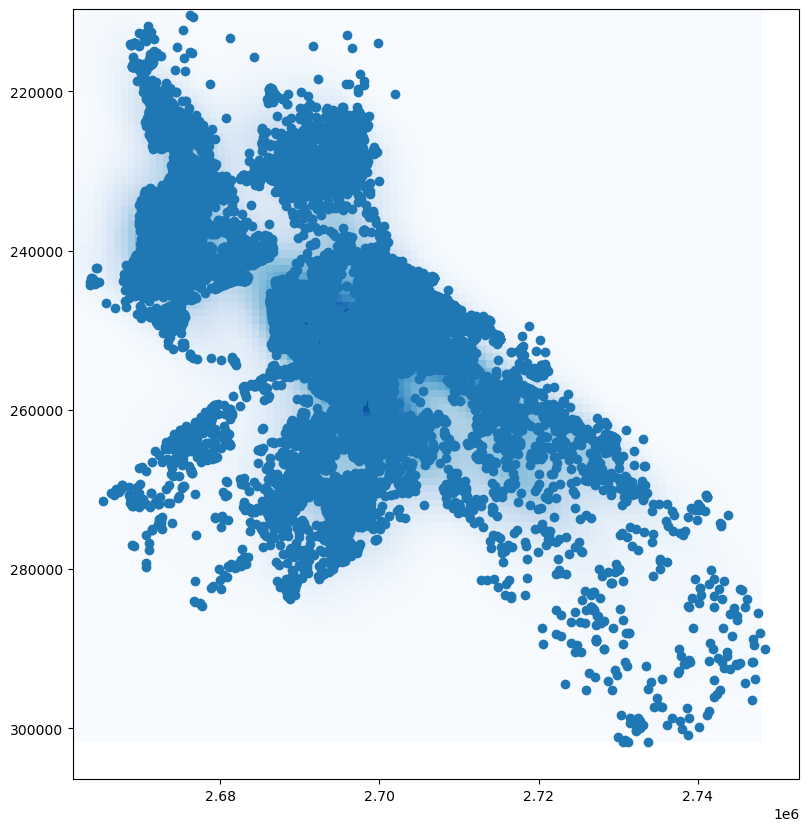

In [47]:
from rasterio.plot import show

fix, ax = plt.subplots(figsize=(10, 10))

extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='Blues')

joined_gdf.plot(ax=ax)

In [48]:
coord_list = [(x,y) for x,y in zip(joined_gdf['centroid'].x, joined_gdf['centroid'].y)]

joined_gdf['guncrime_density'] = [x for x in src.sample(coord_list)]

# convert 'guncrime_density' column to float
joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].astype(float)

<AxesSubplot: >

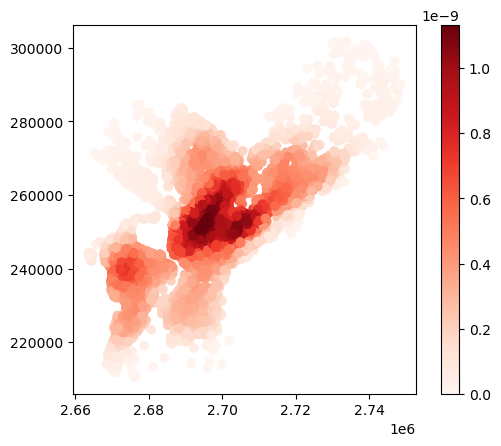

In [49]:
# plot the centroids with the guncrime density as the color
joined_gdf.plot(column='guncrime_density', cmap='Reds', legend=True)

Reclassify data into percentiles.

In [50]:
guncrime_classifier = mapclassify.Percentiles(joined_gdf['guncrime_density'], pct=[50, 75, 90, 95, 99, 100])

joined_gdf['guncrime_density'] = joined_gdf[['guncrime_density']].apply(guncrime_classifier)

joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].replace([0, 1, 2, 3, 4, 5], ['Bottom 50%', 'Top 50%', 'Top 25%', 'Top 10%', 'Top 5%', 'Top 1%'])

In [51]:
# need to triple check that I'm calculating this right--is it absolute value?

tree_classifier = mapclassify.Percentiles(joined_gdf['tree_canopy_gap'], pct=[50, 75, 90, 95, 99, 100])

joined_gdf['tree_canopy_gap'] = joined_gdf[['tree_canopy_gap']].apply(tree_classifier)

joined_gdf['tree_canopy_gap'] = joined_gdf['tree_canopy_gap'].replace([0, 1, 2, 3, 4, 5], ['Bottom 50%', 'Top 50%', 'Top 25%', 'Top 10%', 'Top 5%', 'Top 1%'])

In [52]:
joined_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos,tree_canopy_gap,guncrime_density
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,NaN,POINT (2687670.347 256881.319),Allegheny West,"East Falls Community Council; PO Box 12672, 19...",Top 50%,Bottom 50%
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2675594.486 242078.492),Haddington,Parkside Association; Parkside Evans Recreatio...,Bottom 50%,Top 50%
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2694579.519 249996.821),Stanton,Uptown Entertainment and Development Corporati...,Bottom 50%,Top 5%
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN,POINT (2699241.653 246723.548),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...,Top 50%,Top 50%
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,POINT (2695050.897 251708.887),Stanton,"Tioga United, Inc.; 1539 W. Venango Street \r\...",Top 10%,Top 1%


In [53]:
# now join the poly_gdf back to the joined_gdf on the opa_id column
joined_gdf = joined_gdf.join(poly_gdf.set_index('OPA_ID'), on='OPA_ID')

# drop the 'centroids' column
#joined_gdf = joined_gdf.drop(columns=['centroid'])

# make 'geometry' the geometry column
joined_gdf = joined_gdf.set_geometry('geometry')

In [54]:
# set all column names to lowercase
joined_gdf.columns = map(str.lower, joined_gdf.columns)

In [55]:
joined_gdf.shape

(36002, 17)

In [56]:
import requests

# Create the SQL query
opa_sql_query = "SELECT parcel_number, market_value FROM opa_properties_public"

# Make the GET request
opa_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": opa_sql_query})

# Get the data
opa_data = opa_response.json()["rows"]

# convert opa_data to a pandas dataframe
opa_df = pd.DataFrame(opa_data)

In [58]:
# join the two dataframes such that opa_id = opa_number
joined_gdf = joined_gdf.merge(opa_df, left_on='opa_id', right_on='parcel_number', how='left')

# drop the parcel_number column
joined_gdf = joined_gdf.drop(columns=['parcel_number'])

joined_gdf.head()

,address,bldg_desc,opa_id,councildistrict,zipcode,type,owner,public_owner,comm_partn,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos,tree_canopy_gap,guncrime_density,geometry,market_value
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,NaN,POINT (2687670.347 256881.319),Allegheny West,"East Falls Community Council; PO Box 12672, 19...",Top 50%,Bottom 50%,"POLYGON ((2687288.180 256633.076, 2687182.041 ...",1499700.0
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2675594.486 242078.492),Haddington,Parkside Association; Parkside Evans Recreatio...,Bottom 50%,Top 50%,"POLYGON ((2675580.787 242097.596, 2675611.032 ...",8100.0
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2694579.519 249996.821),Stanton,Uptown Entertainment and Development Corporati...,Bottom 50%,Top 5%,"POLYGON ((2694595.619 250002.049, 2694595.572 ...",17400.0
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN,POINT (2699241.653 246723.548),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...,Top 50%,Top 50%,"POLYGON ((2699250.966 246745.116, 2699244.163 ...",49000.0
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,POINT (2695050.897 251708.887),Stanton,"Tioga United, Inc.; 1539 W. Venango Street \r\...",Top 10%,Top 1%,"POLYGON ((2695073.865 251698.897, 2695026.121 ...",21700.0


In [59]:
# Create the SQL query
delinq_sql_query = "SELECT * FROM real_estate_tax_delinquencies"

# Make the GET request
delinq_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": delinq_sql_query})

# Get the data
delinq_data = delinq_response.json()["rows"]

# convert delinq_data to a pandas dataframe
delinq_df = pd.DataFrame(delinq_data)

In [60]:
red_cols_to_keep = ['opa_number', 
                    'total_due', 
                    'is_actionable',
                    'payment_agreement', 
                    'num_years_owed', 
                    'most_recent_year_owed', 
                    'total_assessment',
                    'sheriff_sale']


red_delinq_df = delinq_df[red_cols_to_keep]


red_delinq_df.head()

,opa_number,total_due,is_actionable,payment_agreement,num_years_owed,most_recent_year_owed,total_assessment,sheriff_sale
0,871051350,83.90,true,false,1,2021,78600.0,N
1,34127500,248.48,true,false,2,2021,40600.0,N
2,34128800,298.10,true,false,1,2021,9000.0,N
3,34130400,96.94,true,false,1,2018,63900.0,N
4,34137700,3330.48,false,true,6,2021,75100.0,N


In [61]:
# convert opa_number to an object
red_delinq_df['opa_number'] = red_delinq_df['opa_number'].astype('string')

C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\482365560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_delinq_df['opa_number'] = red_delinq_df['opa_number'].astype('string')


In [62]:
# join the two dataframes such that opa_id = opa_number
joined_gdf = joined_gdf.merge(red_delinq_df, left_on='opa_id', right_on='opa_number', how='left')

In [63]:
# Define the conditions and values to assign for each condition
cond1 = joined_gdf["public_owner"]
val1 = "Deed from City"

cond2 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].isna())
val2 = "Work with owner"

cond3 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] > 3)
val3 = "Sherrif's sale"

cond4 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (joined_gdf["owner"].str.contains("LLC"))
val4 = "Force foreclosure"

cond5 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (~joined_gdf["owner"].str.contains("LLC")) & (joined_gdf["market_value"] < 100000)
val5 = "Buy from owner"

cond6 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (~joined_gdf["owner"].str.contains("LLC")) & (joined_gdf["market_value"] >= 100000)
val6 = "Turn over to developer"

# Use np.select to create the new column based on the conditions and values
joined_gdf["acquisition_process"] = np.select([cond1, cond2, cond3, cond4, cond5, cond6], [val1, val2, val3, val4, val5, val6], default="Too complicated")

In [64]:
tree_cond1 = (joined_gdf["guncrime_density"] == "Bottom 50%") & ((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%"))
tree_val1 = "Low Priority"

tree_cond2 = ((joined_gdf["guncrime_density"] == "Top 50%") & ((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%"))) | ((joined_gdf["guncrime_density"] == "Bottom 50%") & ~((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%")))
tree_val2 = "Medium Priority"

joined_gdf["priority_level"] = np.select([tree_cond1, tree_cond2], [tree_val1, tree_val2], default="High Priority")

In [67]:
# adds a column to link users to the atlas page for each property
joined_gdf['atlas_url'] = '<a href="https://atlas.phila.gov/' + joined_gdf['address'] + '">Click here</a>'

In [68]:
joined_gdf.head()

,address,bldg_desc,opa_id,councildistrict,zipcode,type,owner,public_owner,comm_partn,li_complaints,...,total_due,is_actionable,payment_agreement,num_years_owed,most_recent_year_owed,total_assessment,sheriff_sale,acquisition_process,priority_level,atlas_url
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work with owner,Low Priority,"<a href=""https://atlas.phila.gov/3232 HENRY AV..."
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deed from City,Medium Priority,"<a href=""https://atlas.phila.gov/633 N 53RD ST..."
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deed from City,High Priority,"<a href=""https://atlas.phila.gov/2424 N MOLE S..."
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work with owner,Medium Priority,"<a href=""https://atlas.phila.gov/437 ARLINGTON..."
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,...,10867.88,true,false,25.0,2021.0,7900.0,N,Sherrif's sale,High Priority,"<a href=""https://atlas.phila.gov/2735 N HICKS ..."


In [69]:
# loop through joined_gdf and return one row per guncrime_density category
guncrime_df = pd.DataFrame()
for i in joined_gdf['guncrime_density'].unique():
    temp_df = joined_gdf[joined_gdf['guncrime_density'] == i]
    guncrime_df = guncrime_df.append(temp_df.sample(n=1))

guncrime_df.head(10)

C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\3508243800.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  guncrime_df = guncrime_df.append(temp_df.sample(n=1))
C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\3508243800.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  guncrime_df = guncrime_df.append(temp_df.sample(n=1))
C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\3508243800.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  guncrime_df = guncrime_df.append(temp_df.sample(n=1))
C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\3508243800.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  guncrime_df = guncrime_df.

,address,bldg_desc,opa_id,councildistrict,zipcode,type,owner,public_owner,comm_partn,li_complaints,...,total_due,is_actionable,payment_agreement,num_years_owed,most_recent_year_owed,total_assessment,sheriff_sale,acquisition_process,priority_level,atlas_url
33111,504 E WALNUT LN,ROW 2 STY MASONRY,592065900,8,19144,Building,WIGGINS JEMAL; WIGGINS BENEATA,False,None,Maintenance Complaint,...,13351.50,true,false,7.0,2021.0,78100.0,N,Sherrif's sale,Low Priority,"<a href=""https://atlas.phila.gov/504 E WALNUT ..."
6192,3120 N CROSKEY ST,VAC LAND RES < ACRE,111342300,8,19132,Lot,ROBERT E LEWIS,False,None,NaN,...,6192.16,true,false,21.0,2021.0,1500.0,N,Sherrif's sale,Medium Priority,"<a href=""https://atlas.phila.gov/3120 N CROSKE..."
35848,1607-09 W ALLEGHENY AVE,DET 3 STY MASONRY,112001800,8,19132,Building,LAM QUANG DUC,False,None,NaN,...,1828.34,true,false,4.0,2021.0,28900.0,N,Sherrif's sale,High Priority,"<a href=""https://atlas.phila.gov/1607-09 W ALL..."
4362,3108 N ROSEWOOD ST,VAC LAND RES < ACRE,111143700,8,19132,Lot,VAZQUEZ SORIA J,False,None,NaN,...,113.55,true,false,2.0,2020.0,8800.0,N,Buy from owner,High Priority,"<a href=""https://atlas.phila.gov/3108 N ROSEWO..."
18545,2409 N CLEVELAND ST,VAC LAND RES < ACRE,162022700,5,19132,Lot,OLADEIO J OGUNFIDODO,False,None,Abandoned Vehicle; Abandoned Vehicle,...,12187.93,true,false,27.0,2021.0,3800.0,N,Sherrif's sale,High Priority,"<a href=""https://atlas.phila.gov/2409 N CLEVEL..."
20505,3335 N 19TH ST,VAC LAND RES < ACRE,112266700,8,19140,Lot,DAY ADVENTIST CHURCH; NORTH PHILA SEVENTH,False,None,NaN,...,1140.09,true,false,4.0,2021.0,7500.0,N,Sherrif's sale,High Priority,"<a href=""https://atlas.phila.gov/3335 N 19TH S..."


In [70]:
guncrime_df.columns

Index(['address', 'bldg_desc', 'opa_id', 'councildistrict', 'zipcode', 'type',
       'owner', 'public_owner', 'comm_partn', 'li_complaints',
       'li_code_violations', 'centroid', 'neighborhood', 'relevant_rcos',
       'tree_canopy_gap', 'guncrime_density', 'geometry', 'market_value',
       'opa_number', 'total_due', 'is_actionable', 'payment_agreement',
       'num_years_owed', 'most_recent_year_owed', 'total_assessment',
       'sheriff_sale', 'acquisition_process', 'priority_level', 'atlas_url'],
      dtype='object')

In [71]:
pct_cmap = {
    'Bottom 50%': '#00876c',
    'Top 50%': '#61a96e',
    'Top 25%': '#aac872',
    'Top 10%': '#f5af5c', 
    'Top 5%' : '#ea784d',
    'Top 1%': '#d43d51'
}

C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\3075049704.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower right',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


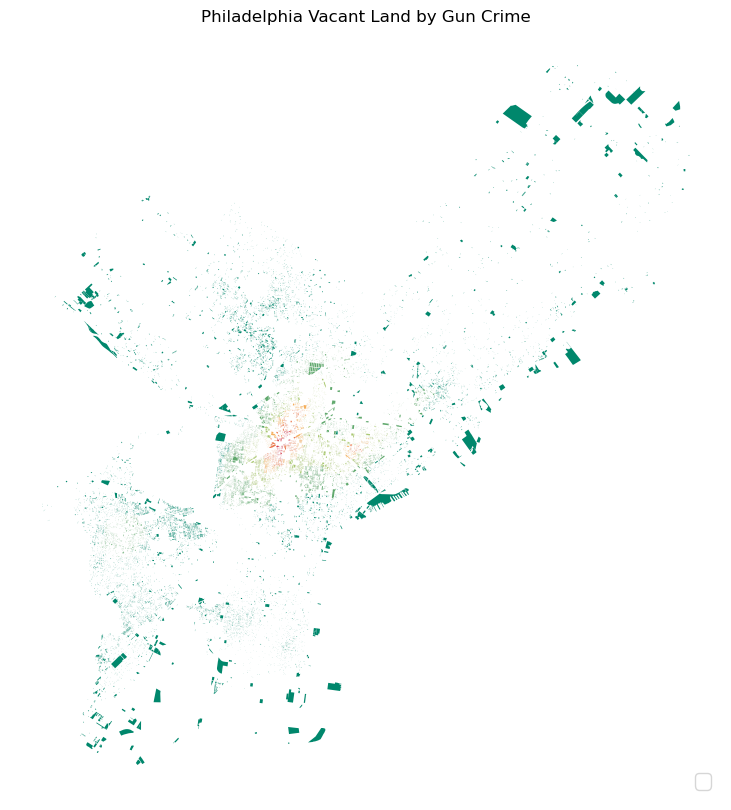

In [72]:
# solution found here: https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-customize-map-legends-geopandas/

# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in joined_gdf.groupby('guncrime_density'):
    
    # Define the color for each group using the dictionary
    color = pct_cmap[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)


ax.set(title='Philadelphia Vacant Land by Gun Crime')
# Place legend in the lower right hand corner of the plot
ax.legend(loc='lower right',
          fontsize=15,
          frameon=True)

ax.set_axis_off()
plt.show()


C:\Users\Nissim\AppData\Local\Temp\ipykernel_33736\420939947.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


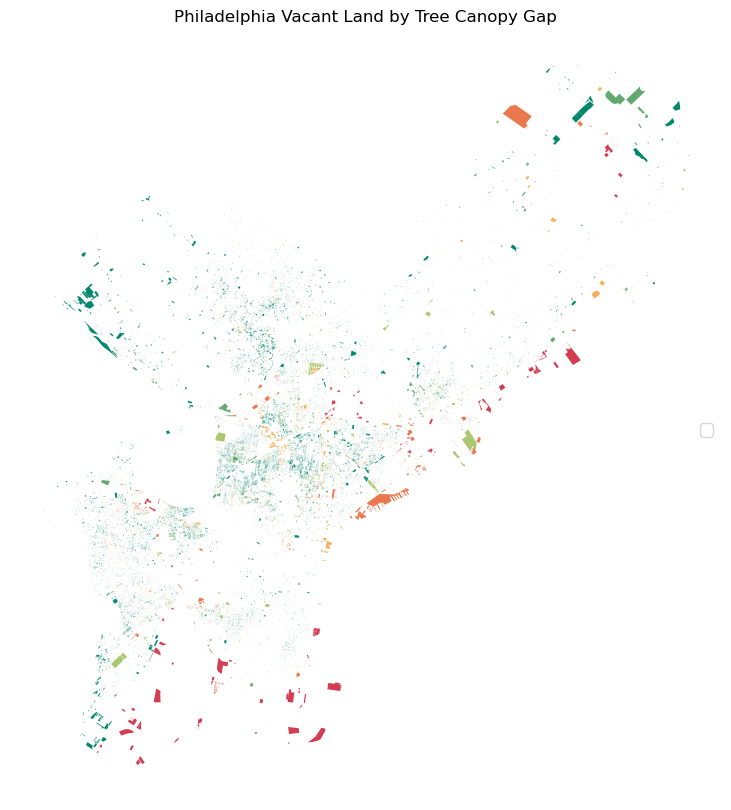

In [73]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in joined_gdf.groupby('tree_canopy_gap'):
    
    # Define the color for each group using the dictionary
    color = pct_cmap[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Philadelphia Vacant Land by Tree Canopy Gap')

ax.set_axis_off()
plt.show()


In [74]:
# reproject to 4326 for mapping
joined_gdf = joined_gdf.to_crs(epsg=4326)

# simplify the geometry
joined_gdf['geometry'] = joined_gdf['geometry'].simplify(5)

joined_gdf_centroids = joined_gdf.set_geometry('centroid')

joined_gdf_centroids = joined_gdf_centroids.drop(columns=['geometry'])

joined_gdf_full = joined_gdf.set_geometry('geometry')

joined_gdf_full = joined_gdf_full.drop(columns=['centroid'])

In [ ]:
# need to add a column for lot size (total area)
# the can convert geoms to points

# remember--originally wanted to display lots and buildings with separate icons. Do I still want to?

In [75]:
joined_gdf_centroids.head()

,address,bldg_desc,opa_id,councildistrict,zipcode,type,owner,public_owner,comm_partn,li_complaints,...,total_due,is_actionable,payment_agreement,num_years_owed,most_recent_year_owed,total_assessment,sheriff_sale,acquisition_process,priority_level,atlas_url
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work with owner,Low Priority,"<a href=""https://atlas.phila.gov/3232 HENRY AV..."
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deed from City,Medium Priority,"<a href=""https://atlas.phila.gov/633 N 53RD ST..."
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deed from City,High Priority,"<a href=""https://atlas.phila.gov/2424 N MOLE S..."
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work with owner,Medium Priority,"<a href=""https://atlas.phila.gov/437 ARLINGTON..."
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,...,10867.88,true,false,25.0,2021.0,7900.0,N,Sherrif's sale,High Priority,"<a href=""https://atlas.phila.gov/2735 N HICKS ..."


In [77]:
from datetime import date

# declare a variable that will call today's date in the format YYYY_MM_DD
today = date.today().strftime("%Y_%m_%d")

# write the joined_gdf to a geojson with a filename that starts with today's date
joined_gdf_centroids.to_file(f"C:/Users/Nissim/Desktop/Vacant Lots Project/vacant-lots-proj/vacancy_guncrime_dash/{today}_joined_gdf_centroids.geojson", driver='GeoJSON')

joined_gdf_full.to_file(f"C:/Users/Nissim/Desktop/Vacant Lots Project/vacant-lots-proj/vacancy_guncrime_dash/{today}_joined_gdf_full.geojson", driver='GeoJSON')